<h1>Second Submission </h1> <br>
Hadar Pinto - 316460146 <br>
Eitan Cohen - 312486376 <br>

**IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_tree
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import os
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")


*The Dataframe*

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
shared_folder_path = '/content/drive/My Drive/tables_data'
os.chdir(shared_folder_path)
df = pd.read_csv('Thyroid_Dataset.csv')

Mounted at /content/drive



Our Goal: In this notebook, we aim to predict the likelihood of recurrence in patients diagnosed with thyroid cancer. We will explore various features in the dataset to identify key points that can be used in the final model, such as correlations, orientations, skewness, and more.

**Data Analysis And Visualization**

In [ ]:
df.head(3)

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No


All features are categorical, besides the feature Age.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   383 non-null    int64 
 1   Gender                383 non-null    object
 2   Smoking               383 non-null    object
 3   Hx Smoking            383 non-null    object
 4   Hx Radiothreapy       383 non-null    object
 5   Thyroid Function      383 non-null    object
 6   Physical Examination  383 non-null    object
 7   Adenopathy            383 non-null    object
 8   Pathology             383 non-null    object
 9   Focality              383 non-null    object
 10  Risk                  383 non-null    object
 11  T                     383 non-null    object
 12  N                     383 non-null    object
 13  M                     383 non-null    object
 14  Stage                 383 non-null    object
 15  Response              383 non-null    ob

The following visualization explores how categorical features relate to cancer recurrence status, helping identify potential risk factors or predictive indicators in concise subplots.

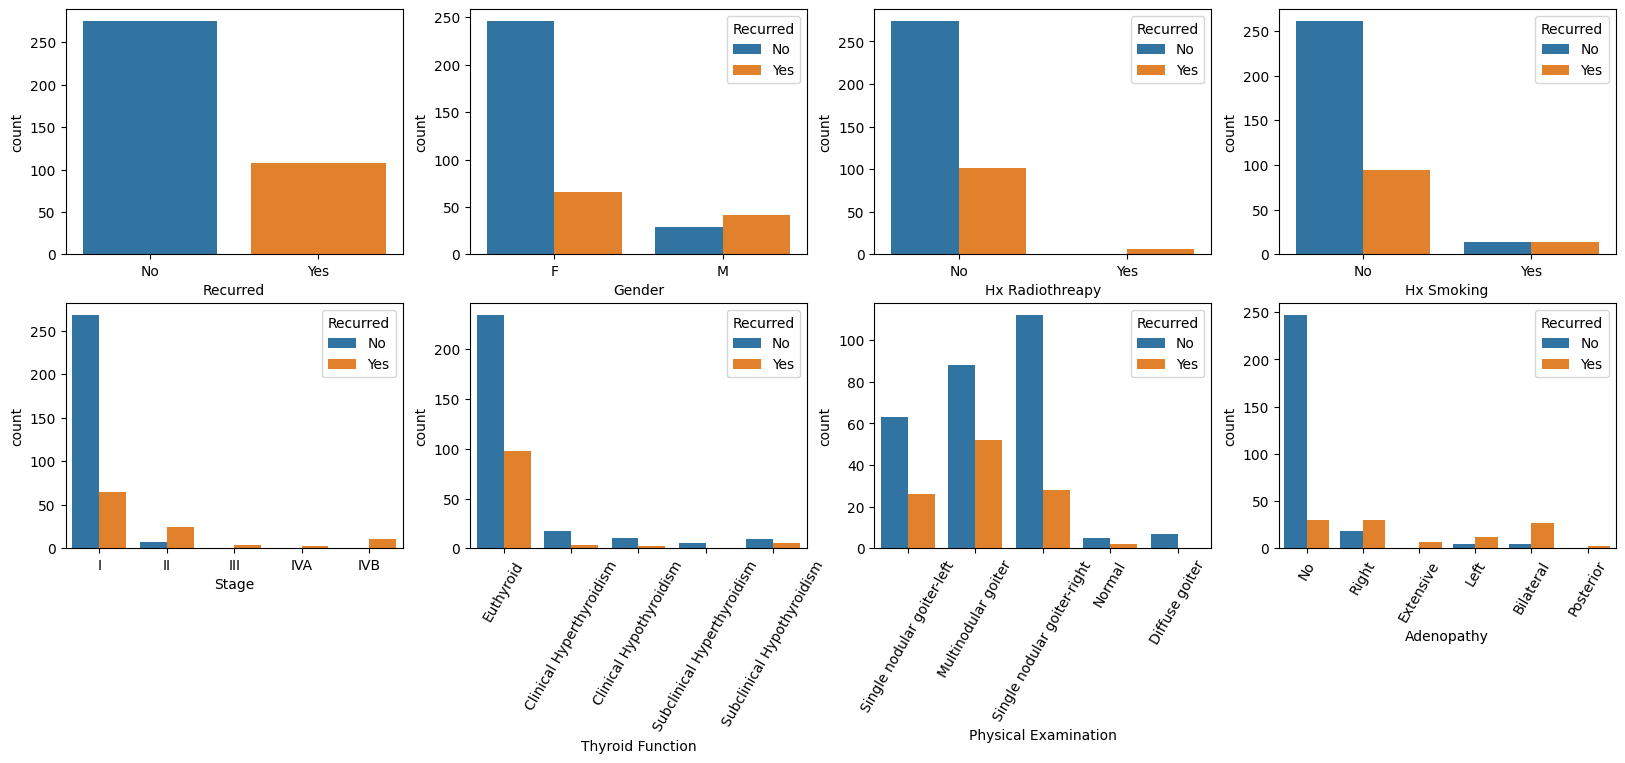

In [29]:
plt.figure(figsize=(20,7))
plt.subplot(241)
sns.countplot(df, x='Recurred', hue='Recurred')
plt.subplot(242)
sns.countplot(df, x='Gender', hue='Recurred')
plt.subplot(243)
sns.countplot(df, x='Hx Radiothreapy', hue ='Recurred')
plt.subplot(244)
sns.countplot(df, x='Hx Smoking', hue='Recurred')
plt.subplot(245)
sns.countplot(data=df, x='Stage', hue='Recurred', order=sorted(df['Stage'].unique()))
plt.subplot(246)
sns.countplot(df, x='Thyroid Function', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(247)
sns.countplot(df, x='Physical Examination', hue='Recurred')
plt.xticks(rotation=60)
plt.subplot(248)
sns.countplot(df, x='Adenopathy', hue='Recurred')
plt.xticks(rotation=60)
plt.show()

Insights:


*   Thyroid cancer exhibits a higher incidence among women, suggesting a gender-based susceptibility to the disease.
*   Most individuals has no history of smoking or radiation.

*  The Majority of participants are confined to Stage I of the disease.
* Skewness is observed towards a single class in the Adenopathy and Thyroid Function features.




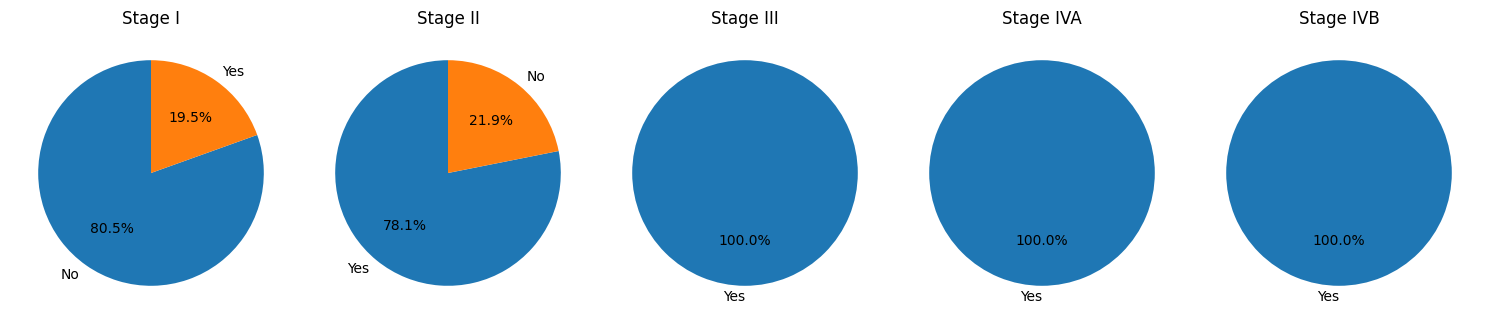

In [38]:
unique_stages = sorted(df['Stage'].unique())

fig, axs = plt.subplots(1, len(unique_stages), figsize=(15, 5))

for i, stage in enumerate(unique_stages):
    stage_df = df[df['Stage'] == stage]

    counts = stage_df['Recurred'].value_counts()

    axs[i].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    axs[i].set_title(f"Stage {stage}")

plt.tight_layout()
plt.show()

**Insight**: For high stages, the 'Recurred' feature exhibits a homogeneous distribution, with only one class present.bold text

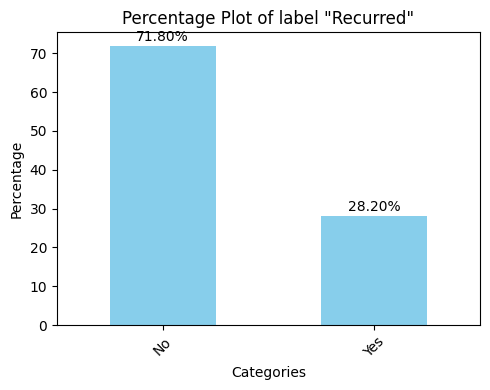

In [ ]:
percentages = df['Recurred'].value_counts(normalize=True) * 100

plt.figure(figsize=(5, 4))
percentages.plot(kind='bar', color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title('Percentage Plot of label "Recurred"')
plt.xticks(rotation=45)

for i, percentage in enumerate(percentages):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

 We observe from the plot that approximately 71.8% of individuals in the dataset are predicted not to experience cancer recurrence. Given this baseline prediction accuracy, we would recommend deploying a machine learning model for prediction purposes only if its accuracy exceeds 72%. Should the model's accuracy fall below this threshold, an alternative approach, such as a simple coin flip, may yield comparable or superior results, thus warranting consideration as an alternative predictive strategy.

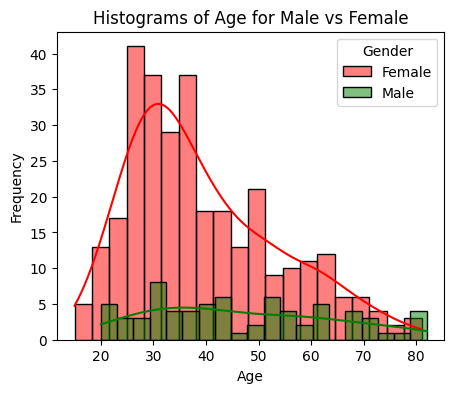

Age    0.719732
dtype: float64

In [30]:
df_female = df[df['Gender'] == 'F']
df_male = df[df['Gender'] == 'M']

plt.figure(figsize=(5, 4))
sns.histplot(df_female['Age'], color='red', label='Female', kde=True, bins=20, alpha=0.5)
sns.histplot(df_male['Age'], color='green', label='Male', kde=True, bins=20, alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histograms of Age for Male vs Female')
plt.legend(title='Gender')
plt.show()
df.skew()

In addition to the calculated skewness, it's observed that the gender and age distributions exhibit positive skewness (right skewness).

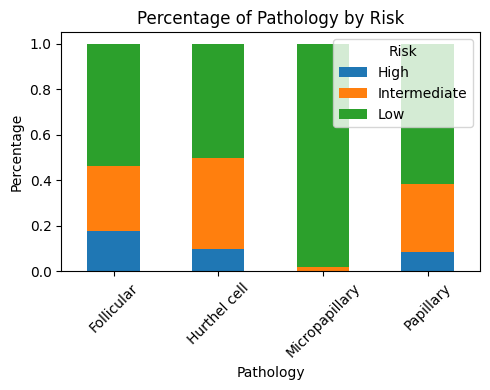

In [ ]:
df = pd.DataFrame(df)

total_counts = df.groupby('Pathology').size()
grouped_counts = df.groupby(['Pathology', 'Risk']).size()
percentages = (grouped_counts / total_counts).unstack(fill_value=0)

percentages.plot(kind='bar', stacked=True, figsize=(5, 4))

plt.title('Percentage of Pathology by Risk')
plt.xlabel('Pathology')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Risk')
plt.tight_layout()
plt.show()

Insight: Comparison of pathological subtypes and risk score revealed that patients with Follicular cancer were more likely to be categorized as high risk. No high-risk patients were found in the micropapillary group.

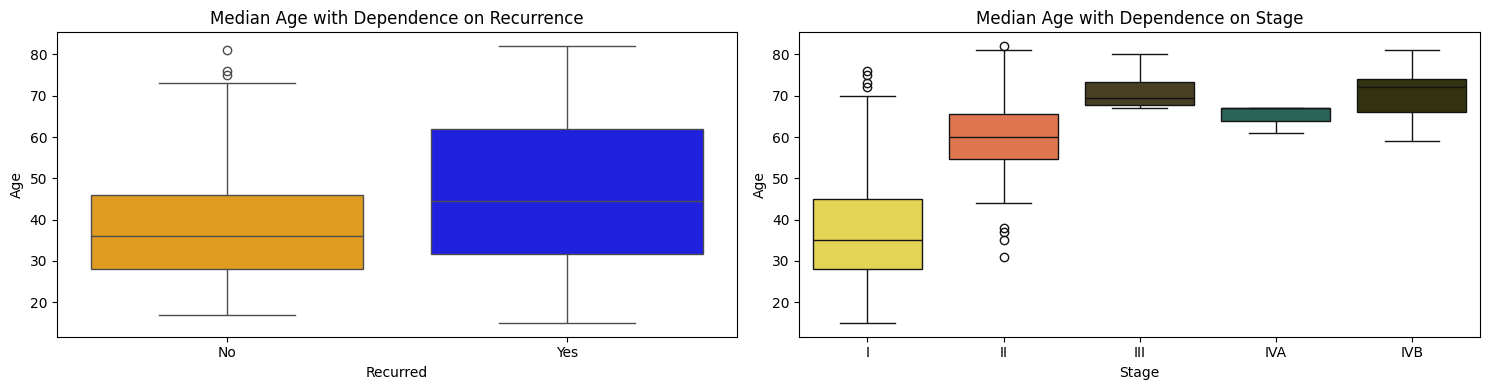

In [ ]:
df = pd.DataFrame(df)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
recurred_colors = {'Yes': 'blue', 'No': 'orange'}

sns.boxplot(ax=axes[0], x='Recurred', y='Age', data=df, palette=recurred_colors)
axes[0].set_title('Median Age with Dependence on Recurrence')
axes[0].set_xlabel('Recurred')
axes[0].set_ylabel('Age')

stages = sorted(df['Stage'].unique())
color_map = {stage: np.random.rand(3,) for stage in stages}

sns.boxplot(ax=axes[1], x='Stage', y='Age', data=df, palette=color_map, order=stages)
axes[1].set_title('Median Age with Dependence on Stage')
axes[1].set_xlabel('Stage')
axes[1].set_ylabel('Age')

plt.tight_layout()

plt.show()

Insight: Higher Median age patients are teniding to have higher staes at diagnosis and recurrence event. <br>
Based on the visualizations, we have a concern regarding potential outliers. Specifically, we suspect that individuals aged over 70 with stage I may be influencing the dataset in an unexpected manner.


In [32]:
count = len(df[(df['Stage'] == 'I') & (df['Age'] > 70) & (df['Recurred'] == 'No')])
print(f"Number of patients with Stage 'I', age over 70, and no recurrence: {count}")

Number of patients with Stage 'I', age over 70, and no recurrence: 4


As we expected, older participants who did not experience recurrence also had a lower stage of cancer initially.

Hypothesis :We can assume that there's a high correlation between Smoking and Hx Smoking, indicating that in this dataset, it's uncommon for a person to change their smoking status.



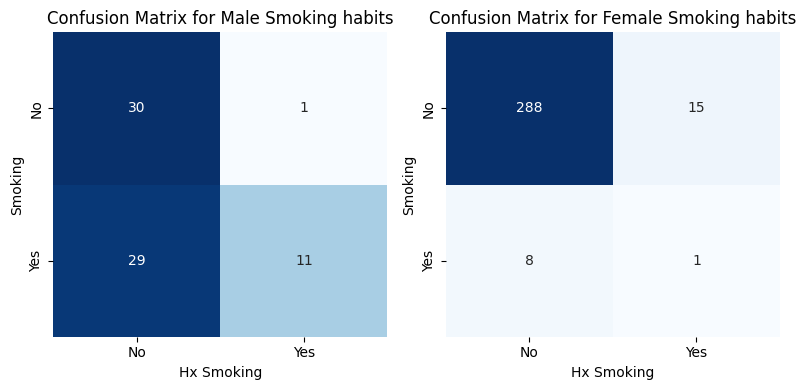

In [ ]:
male_df = df[df['Gender'] == 'M']
female_df = df[df['Gender'] == 'F']

male_conf_matrix = pd.crosstab(male_df['Smoking'], male_df['Hx Smoking'])
female_conf_matrix = pd.crosstab(female_df['Smoking'], female_df['Hx Smoking'])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.heatmap(male_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix for Male Smoking habits')
axs[0].set_xlabel('Hx Smoking')
axs[0].set_ylabel('Smoking')

sns.heatmap(female_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix for Female Smoking habits')
axs[1].set_xlabel('Hx Smoking')
axs[1].set_ylabel('Smoking')

plt.tight_layout()
plt.show()

Insight: We can assume that for female there's high correltion in Smoking and Hx Smoking so that in this dataset it's not common that a person changed her Smoking habits for men we can see lower corrletion and more changings in Smoking habits.


<H2> Correlations

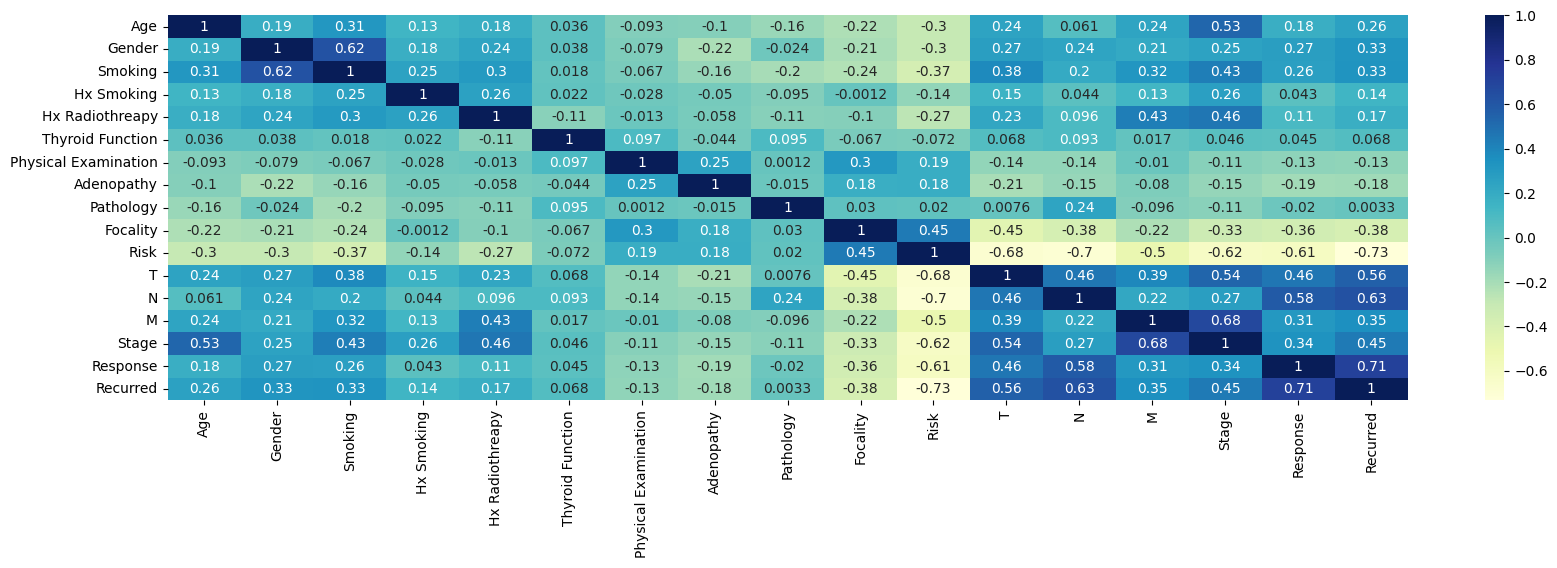

In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_columns:
  df[col] = le.fit_transform(df[col])
plt.figure(figsize=(20, 5))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

It's noted that there is a high correlation between the feature Risk to the feature Stage, and between the feature Risk to our label Recurred. <br>
High correlation between a feature and the label risks overfitting, misinterpretation, loss of generalization, and violation of assumptions, therefore we should consider decisions on feature removal. <br>
However, apart from this correlation, there are no other notable high correlations among the features in the dataset.

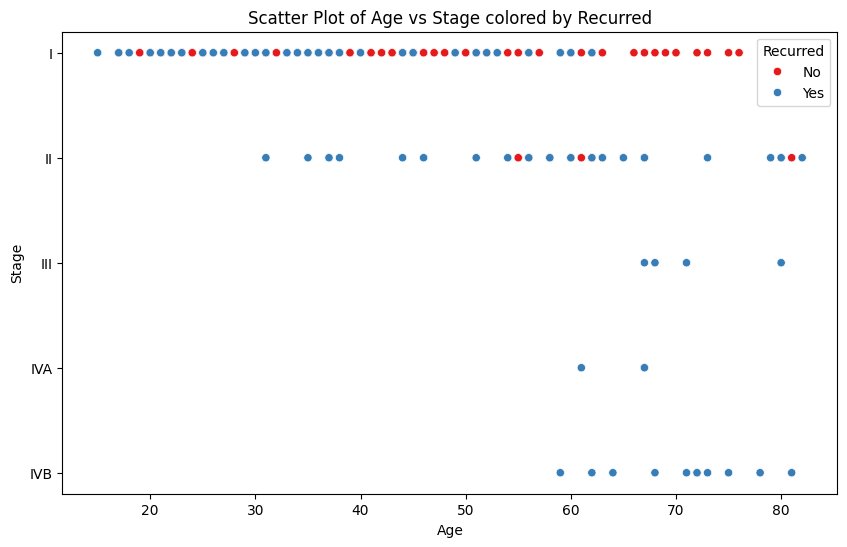

In [36]:
plt.figure(figsize=(10, 6))
df['Stage'] = pd.Categorical(df['Stage'], categories=sorted(df['Stage'].unique()), ordered=True)
sns.scatterplot(x='Age', y='Stage', hue='Recurred', data=df, palette='Set1')
plt.xlabel('Age')
plt.ylabel('Stage')
plt.title('Scatter Plot of Age vs Stage colored by Recurred')
plt.show()

Based on our analysis using two features from the dataset, we were unable to find a clear separation between the domains that align with the correct labels.

In [37]:
import plotly.express as px

fig = px.scatter_3d(df, x='Age', y='Thyroid Function', z='Physical Examination', color='Recurred',
                     symbol='Recurred', opacity=0.7, size_max=10)
fig.update_layout(title='3D Scatter Plot of Age, Stage, and Smoking colored by Recurred',
                  scene=dict(xaxis_title='Age', yaxis_title='Stage', zaxis_title='Risk'))
fig.show()


After analyzing the correlation heatmap, we aimed to investigate if there are any outliers in the dataset, particularly focusing on the three features that are scored as minimum. The heatmap indicated the presence of outliers. Considering this, we concluded that an SVM classifier model would be the most suitable approach to address this issue

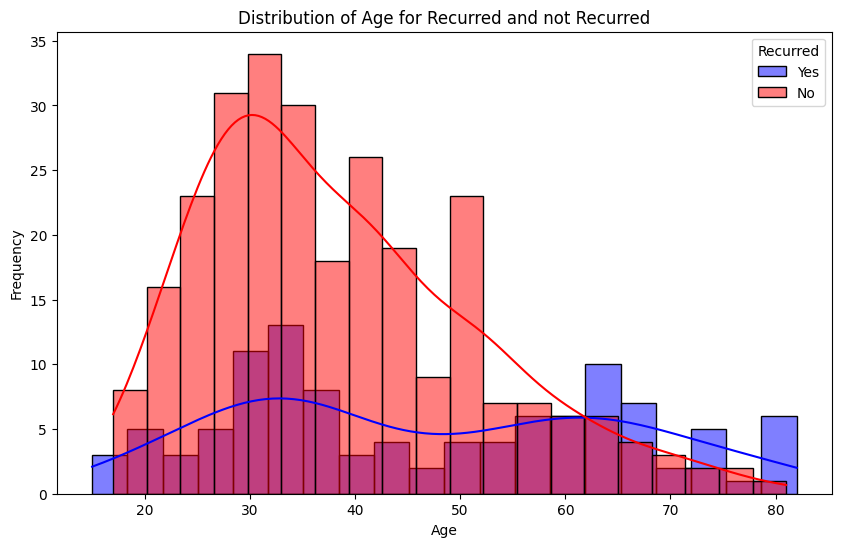

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for 'Y' label
sns.histplot(df[df['Recurred'] == 'Yes']['Age'], bins=20, kde=True, color='blue', label='Yes')

# Plot for 'N' label
sns.histplot(df[df['Recurred'] == 'No']['Age'], bins=20, kde=True, color='red', label='No')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Recurred and not Recurred')
plt.legend(title='Recurred')
plt.show()


Insight: from those results we can assume that high age might indicated on high probablity for reccuring

*XGBOOST Model*

Accuracy is: 0.9674193548387097


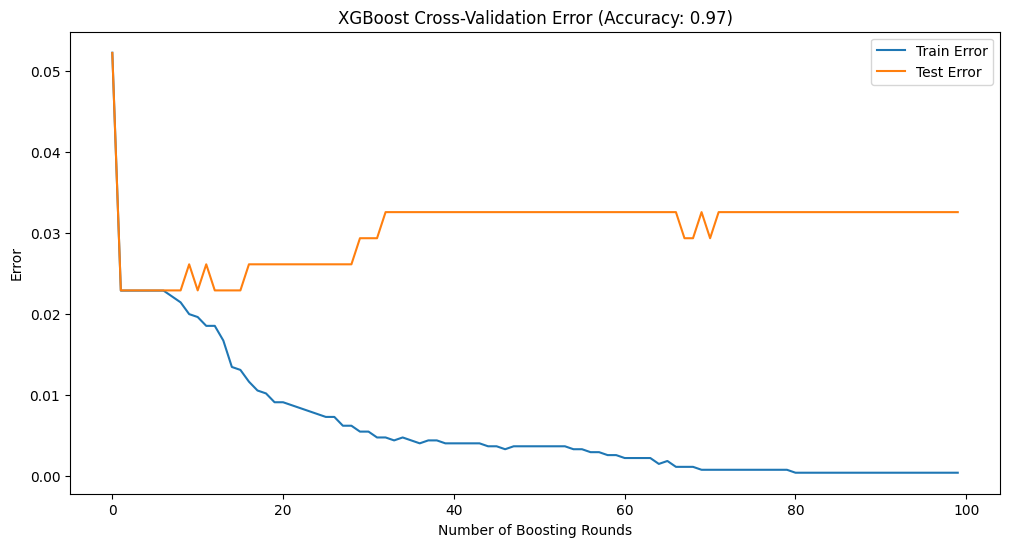

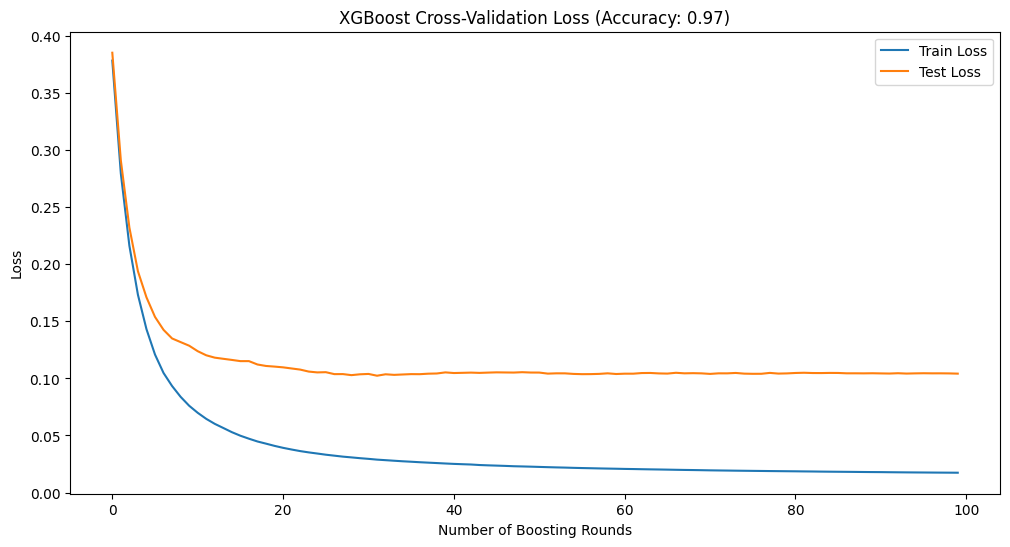

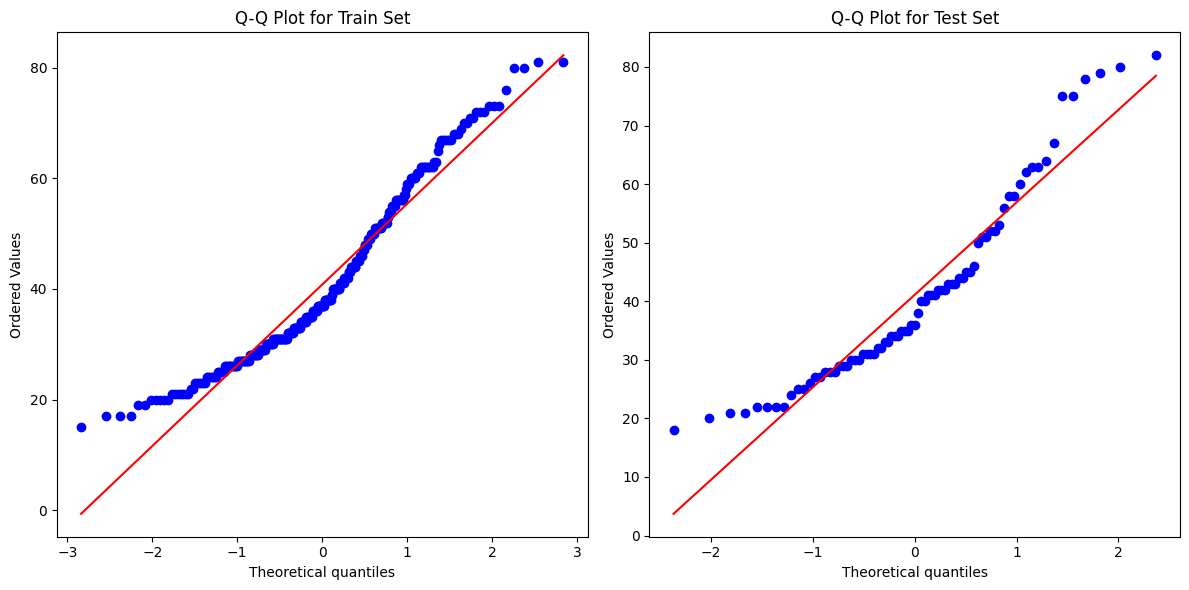

In [21]:
X = df.drop(columns=['Recurred'])
y = df['Recurred']

# adapt categorical classes
label_encoders = {}
for feature in X.select_dtypes(include=['object']).columns:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
y = y.replace({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = xgb.XGBClassifier()

cv_results = xgb.cv(params=model.get_xgb_params(),
                    dtrain=xgb.DMatrix(X_train, label=y_train),
                    num_boost_round=100,  # Set to the number of boosting rounds you want
                    nfold=10,
                    metrics=['logloss', 'error'])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = 1 - cv_results['test-error-mean'].iloc[-1]
print("Accuracy is:", accuracy)

plt.figure(figsize=(12, 6))
plt.plot(cv_results['train-error-mean'], label='Train Error')
plt.plot(cv_results['test-error-mean'], label='Test Error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Cross-Validation Error (Accuracy: {:.2f})'.format(accuracy))
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(cv_results['train-logloss-mean'], label='Train Loss')
plt.plot(cv_results['test-logloss-mean'], label='Test Loss')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Loss')
plt.title('XGBoost Cross-Validation Loss (Accuracy: {:.2f})'.format(accuracy))
plt.legend()
plt.show()

train_quantiles = np.linspace(0, 1, len(X_train))
test_quantiles = np.linspace(0, 1, len(X_test))

train_quantile_values = np.quantile(X_train['Age'], train_quantiles)
test_quantile_values = np.quantile(X_test['Age'], test_quantiles)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(X_train['Age'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Train Set')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')

plt.subplot(1, 2, 2)
stats.probplot(X_test['Age'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Test Set')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')

plt.tight_layout()
plt.show()

Results:<br>
The Q-Q plots indicate that the train and test sets have similar distributions, as expected.<br>
The XGBoost model achieved high performance with an accuracy of 96%.<br>
Based on the plots of the loss and error, we might assume that there's an overfitting issue, which we will address in our next steps in our final project.

show corrletion - rccurened vs stage (for each stage)